In [1]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import struct
from array import array

def load_binary(img_path, lbl_path):

    # open file in binary read mode
    with open(lbl_path, "rb") as f:
        # first 8 bytes contain metadata as two 32-bit integers in big-endian byte order
        magic, size = struct.unpack(">II", f.read(8))
        assert magic == 2049, f"Magic number should be 2049, got {magic}"

        labels = array("B", f.read())

    with open(img_path, "rb") as f:
        # first 16 bytes contain metadata as four integers
        magic, size, rows, cols = struct.unpack(">IIII", f.read(16))
        assert magic == 2051, f"Magic number should be 2051, got {magic}"

        image_data = array("B", f.read())

    # initialize a list to store the image bytes
    images = []
    for i in range(size):
        images.append([0] * rows * cols)

    # populate the list with the image bytes
    for i in range(size):
        images[i][:] = image_data[i * rows * cols : (i + 1) * rows * cols]

    return images, labels


def load_mnist_binary(thresh=0.5):
    train_img_path = r"data/mnist/train-images-idx3-ubyte"
    train_lbl_path = r"data/mnist/train-labels-idx1-ubyte"

    train_img, train_lbl = load_binary(train_img_path, train_lbl_path)

    test_img_path = r"data/mnist/t10k-images-idx3-ubyte"
    test_lbl_path = r"data/mnist/t10k-labels-idx1-ubyte"

    test_img, test_lbl = load_binary(test_img_path, test_lbl_path)

    # stack them to process them together
    X_ = np.vstack((train_img, test_img))
    y_ = np.hstack((train_lbl, test_lbl))

    # scale the image pixel values to the range [0, 1]
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_tf = scaler.fit_transform(X_)

    # binarize the image pixel values
    X = (X_tf > thresh).astype(bool)
    y = (y_ == 5) | (y_ == 6) | (y_ == 7) | (y_ == 8) | (y_ == 9)

    X_train = X[:60_000]
    X_test = X[60_000:]
    y_train = y[:60_000]
    y_test = y[60_000:]

    return X_train, X_test, y_train, y_test

In [2]:
import matplotlib.pyplot as plt

from ripper_lut_net import *

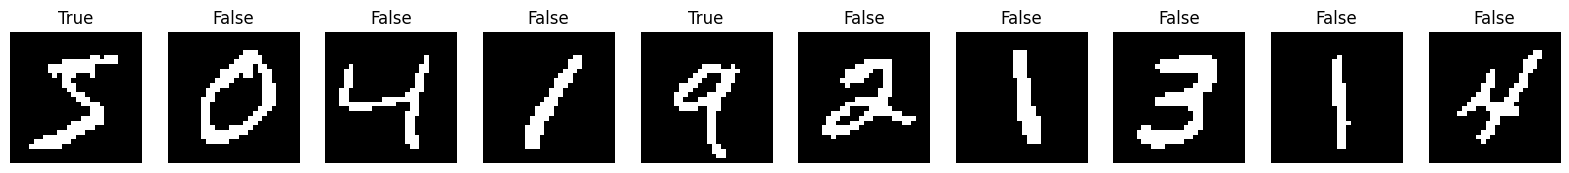

In [3]:
X_train, X_test, y_train, y_test = load_mnist_binary()

# ripper takes extremely long. so I will just use a limited subset of the data
X_train = X_train[:10000]
y_train = y_train[:10000]
X_test = X_test[:1500]
y_test = y_test[:1500]

fig, axs = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    axs[i].imshow(X_train[i].reshape(28, 28), cmap='gray')
    axs[i].set_title(y_train[i])
    axs[i].axis('off')

In [4]:
%%time

# simple test whether it works

lut_bits = 6
num_layers = 5

lut_net = RipperLut(bits=[lut_bits] * (num_layers + 1), hidden_layers=[32] * num_layers, verbose=True, mode='lut')
preds_train = lut_net.train(X_train, y_train)
preds_test = lut_net.predict(X_test)
print(f"Accuracy on training set: {accuracy_score(preds_train, y_train):.2f}")
print(f"Accuracy on test set: {accuracy_score(preds_test, y_test):.2f}")

100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Accuracy on training set: 0.82
Accuracy on test set: 0.75
CPU times: user 196 ms, sys: 475 ms, total: 671 ms
Wall time: 5.61 s


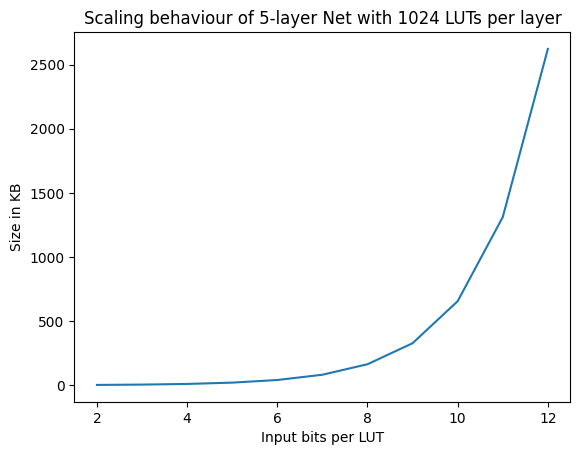

In [5]:
# experiment: size vs. number of input bits (i.e. "arity")

num_layers = 5
num_layer_luts = 1024
nums_lut_bits = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

lut_network_sizes = [get_lut_size(num_lut_bits, [num_layer_luts] * num_layers + [1]) / 1000 for num_lut_bits in nums_lut_bits]

plt.plot(nums_lut_bits, lut_network_sizes)
plt.title("Scaling behaviour of 5-layer Net with 1024 LUTs per layer")
plt.xlabel("Input bits per LUT")
plt.ylabel("Size in KB")
plt.show()

100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Text(0, 0.5, 'Accuracy')

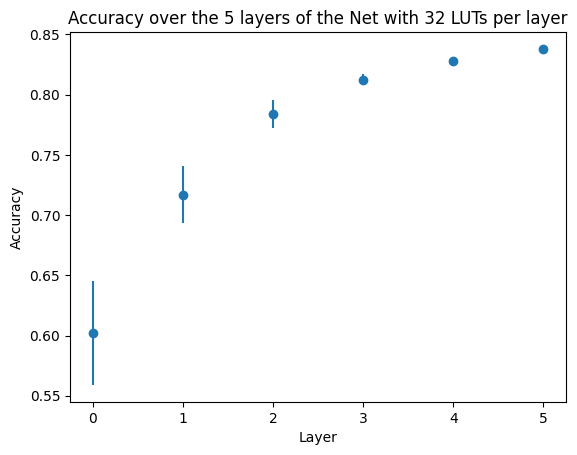

In [6]:
# experiment: accuracies over depth

num_layers = 5
num_layer_luts = 32
nums_lut_bits = 6

lut = RipperLut(bits=[nums_lut_bits] * (num_layers + 1), hidden_layers=[num_layer_luts] * num_layers, verbose=True, mode='lut')
preds_train = lut.train(X_train, y_train)
preds, accs = lut.get_accuracies_per_layer(X_train, y_train)

mean_accs = [np.mean(acc) for acc in accs]
std_accs = [np.std(acc) for acc in accs]

# plot over layers with std
plt.errorbar(range(num_layers + 1), mean_accs, yerr=std_accs, fmt='o')
plt.title(f"Accuracy over the 5 layers of the Net with {num_layer_luts} LUTs per layer")
plt.xlabel("Layer")
plt.ylabel("Accuracy")

2 LUTs per layer: Accuracy on training set: 0.62
2 LUTs per layer: Accuracy on test set: 0.59
4 LUTs per layer: Accuracy on training set: 0.71
4 LUTs per layer: Accuracy on test set: 0.69
8 LUTs per layer: Accuracy on training set: 0.75
8 LUTs per layer: Accuracy on test set: 0.71
16 LUTs per layer: Accuracy on training set: 0.83
16 LUTs per layer: Accuracy on test set: 0.78
32 LUTs per layer: Accuracy on training set: 0.88
32 LUTs per layer: Accuracy on test set: 0.78
64 LUTs per layer: Accuracy on training set: 0.92
64 LUTs per layer: Accuracy on test set: 0.82


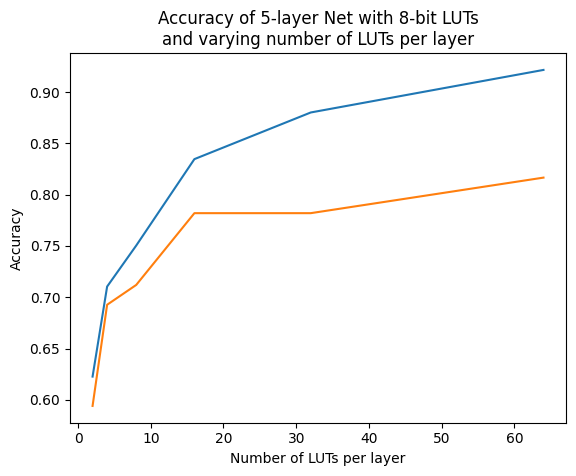

In [7]:
# experiment: accuracies with changing number of LUTs per hidden layer

num_layers = 5
nums_layer_luts = [2, 4, 8, 16, 32, 64] #, 128, 256, 512, 1024, 2048, 4096]
nums_lut_bits = 8

train_accuracies = []
test_accuracies = []
for num_layer_luts in nums_layer_luts:
    lut = RipperLut(bits=[nums_lut_bits] * (num_layers + 1), hidden_layers=[num_layer_luts] * num_layers, verbose=False, mode='lut')

    preds_train = lut.train(X_train, y_train)
    preds_test = lut.predict(X_test)

    train_accuracy = accuracy_score(preds_train, y_train)
    test_accuracy = accuracy_score(preds_test, y_test)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    print(f"{num_layer_luts} LUTs per layer: Accuracy on training set: {train_accuracy:.2f}")
    print(f"{num_layer_luts} LUTs per layer: Accuracy on test set: {test_accuracy:.2f}")
    

plt.plot(nums_layer_luts, train_accuracies, label="Train")
plt.plot(nums_layer_luts, test_accuracies, label="Test")
plt.title("Accuracy of 5-layer Net with 8-bit LUTs\nand varying number of LUTs per layer")
plt.xlabel("Number of LUTs per layer")
plt.ylabel("Accuracy")
plt.show()

2 bits per LUT: Accuracy on training set: 0.66
2 bits per LUT: Accuracy on test set: 0.65
4 bits per LUT: Accuracy on training set: 0.82
4 bits per LUT: Accuracy on test set: 0.81
8 bits per LUT: Accuracy on training set: 0.94
8 bits per LUT: Accuracy on test set: 0.83


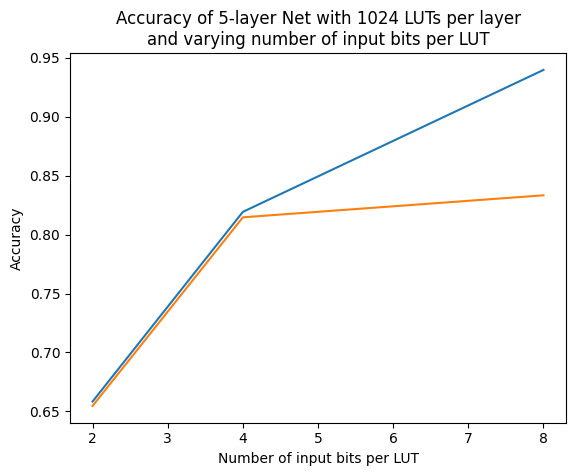

In [8]:
# experiment: accuracies with changing number of input bits per LUT

num_layers = 5
num_layer_luts = 512 # because of time constraints with ripper
nums_lut_bits = [2, 4, 8] #, 16]

train_accuracies = []
test_accuracies = []
for num_lut_bits in nums_lut_bits:
    lut = RipperLut(bits=[num_lut_bits] * (num_layers + 1), hidden_layers=[num_layer_luts] * num_layers, verbose=False, mode='lut')

    preds_train = lut.train(X_train, y_train)
    preds_test = lut.predict(X_test)

    train_accuracy = accuracy_score(preds_train, y_train)
    test_accuracy = accuracy_score(preds_test, y_test)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    print(f"{num_lut_bits} bits per LUT: Accuracy on training set: {train_accuracy:.2f}")
    print(f"{num_lut_bits} bits per LUT: Accuracy on test set: {test_accuracy:.2f}")
    
    
plt.plot(nums_lut_bits, train_accuracies, label="Train")
plt.plot(nums_lut_bits, test_accuracies, label="Test")
plt.title("Accuracy of 5-layer Net with 1024 LUTs per layer\nand varying number of input bits per LUT")
plt.xlabel("Number of input bits per LUT")
plt.ylabel("Accuracy")
plt.show()